# Test Notebook
This notebook is here to test things (ideas/functions/implementations/etc) out. Each section should be independent of any other section.

## Analyzing toy data set size/composition

In [2]:
import pandas as pd

In [3]:
train = pd.read_csv('protocols/p0_train.csv', header=None)
val   = pd.read_csv('protocols/p0_val.csv', header=None)
test  = pd.read_csv('protocols/p0_test.csv', header=None)

In [4]:
datasets = [('train', train), ('val', val), ('test', test)]

metadata = {}
total_size = 0

for d in datasets:
    name = d[0]
    data = d[1]

    metadata[name] = {}

    # compute dataset size
    metadata[name]['n'] = data.shape[0]
    total_size += metadata[name]['n']

    # compute known/negative/unknown split sizes
    metadata[name]['n_kn']  = data[data[1] >= 0].shape[0]
    metadata[name]['n_neg'] = data[data[1] == -1].shape[0]
    metadata[name]['n_unk'] = data[data[1] == -2].shape[0]

    metadata[name]['n_kn_percent']  = round(metadata[name]['n_kn']/metadata[name]['n'] , 2)*100
    metadata[name]['n_neg_percent'] = round(metadata[name]['n_neg']/metadata[name]['n'], 2)*100
    metadata[name]['n_unk_percent'] = round(metadata[name]['n_unk']/metadata[name]['n'], 2)*100

    print(f"size {name}: \t{metadata[name]['n']}")
    print(f"\t{name} known:     {metadata[name]['n_kn']} ({metadata[name]['n_kn_percent']}%)")
    print(f"\t{name} negatives: {metadata[name]['n_neg']} ({metadata[name]['n_neg_percent']}%)")
    print(f"\t{name} unknown:   {metadata[name]['n_unk']} ({metadata[name]['n_unk_percent']}%)")
    

print(f"size total: \t{total_size}")

size train: 	97920
	train known:     48000 (49.0%)
	train negatives: 49920 (51.0%)
	train unknown:   0 (0.0%)
size val: 	24480
	val known:     12000 (49.0%)
	val negatives: 12480 (51.0%)
	val unknown:   0 (0.0%)
size test: 	30800
	test known:     10000 (32.0%)
	test negatives: 10400 (34.0%)
	test unknown:   10400 (34.0%)
size total: 	153200


## Normalizing array

In [23]:
import numpy as np

features = np.random.rand(5,2)
features

array([[0.20620936, 0.04435235],
       [0.72144327, 0.50506758],
       [0.97917433, 0.5126422 ],
       [0.38295848, 0.86357367],
       [0.88862559, 0.42341483]])

In [ ]:
def normalize_array(array, axis, ord=2):
    norms = np.linalg.norm(array, axis=axis, ord=ord)
    norms = norms.reshape((-1,1))  # reshape norms to same dim as array
    array = np.divide(array, norms)  # normalize
    return array

In [24]:
norms = np.linalg.norm(features, axis=1, ord=2)
norms

array([0.21092518, 0.8806666 , 1.10525309, 0.94467808, 0.98434524])

In [25]:
norms = norms.reshape((-1,1))
norms

array([[0.21092518],
       [0.8806666 ],
       [1.10525309],
       [0.94467808],
       [0.98434524]])

In [29]:
# norms = norms.repeat(2, axis=1)
# norms

array([[0.21092518, 0.21092518],
       [0.8806666 , 0.8806666 ],
       [1.10525309, 1.10525309],
       [0.94467808, 0.94467808],
       [0.98434524, 0.98434524]])

In [27]:
feats = np.divide(features, norms)
feats

array([[0.97764222, 0.21027526],
       [0.81920136, 0.573506  ],
       [0.8859277 , 0.46382336],
       [0.40538517, 0.91414598],
       [0.90275805, 0.43014871]])

In [28]:
n = np.linalg.norm(feats, axis=1, ord=2)
n

array([1., 1., 1., 1., 1.])

## Test angular margin

In [32]:
import torch.nn.functional as F
import math

In [43]:
w = torch.ones((3,5))
features = torch.ones((10,3))
labels = torch.tensor([0,0,0,1,1,1,2,2,2,3])

w = F.normalize(w, dim=0)
cos_theta = F.normalize(features, dim=1).mm(w)
cos_theta

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])

In [44]:
m = .35

theta_m = torch.acos(cos_theta.clamp(-1+1e-5, 1-1e-5))
theta_m.scatter_(1, labels.view(-1, 1), m, reduce='add')
theta_m.clamp_(1e-5, math.pi)
theta_m

tensor([[0.3545, 0.0045, 0.0045, 0.0045, 0.0045],
        [0.3545, 0.0045, 0.0045, 0.0045, 0.0045],
        [0.3545, 0.0045, 0.0045, 0.0045, 0.0045],
        [0.0045, 0.3545, 0.0045, 0.0045, 0.0045],
        [0.0045, 0.3545, 0.0045, 0.0045, 0.0045],
        [0.0045, 0.3545, 0.0045, 0.0045, 0.0045],
        [0.0045, 0.0045, 0.3545, 0.0045, 0.0045],
        [0.0045, 0.0045, 0.3545, 0.0045, 0.0045],
        [0.0045, 0.0045, 0.3545, 0.0045, 0.0045],
        [0.0045, 0.0045, 0.0045, 0.3545, 0.0045]])

In [45]:
d_theta = torch.cos(theta_m) - cos_theta
d_theta

tensor([[-6.2171e-02, -9.9540e-06, -9.9540e-06, -9.9540e-06, -9.9540e-06],
        [-6.2171e-02, -9.9540e-06, -9.9540e-06, -9.9540e-06, -9.9540e-06],
        [-6.2171e-02, -9.9540e-06, -9.9540e-06, -9.9540e-06, -9.9540e-06],
        [-9.9540e-06, -6.2171e-02, -9.9540e-06, -9.9540e-06, -9.9540e-06],
        [-9.9540e-06, -6.2171e-02, -9.9540e-06, -9.9540e-06, -9.9540e-06],
        [-9.9540e-06, -6.2171e-02, -9.9540e-06, -9.9540e-06, -9.9540e-06],
        [-9.9540e-06, -9.9540e-06, -6.2171e-02, -9.9540e-06, -9.9540e-06],
        [-9.9540e-06, -9.9540e-06, -6.2171e-02, -9.9540e-06, -9.9540e-06],
        [-9.9540e-06, -9.9540e-06, -6.2171e-02, -9.9540e-06, -9.9540e-06],
        [-9.9540e-06, -9.9540e-06, -9.9540e-06, -6.2171e-02, -9.9540e-06]])

In [46]:
cos_theta + d_theta

tensor([[0.9378, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.9378, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.9378, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.9378, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.9378, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.9378, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.9378, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.9378, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.9378, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 0.9378, 1.0000]])

In [48]:
# my version
w = torch.ones((3,5))
features = torch.ones((10,3))
labels = torch.tensor([0,0,0,1,1,1,2,2,2,3])

w = F.normalize(w, dim=0)
cos_theta = F.normalize(features, dim=1).mm(w)

theta_m = torch.acos(cos_theta.clamp(-1+1e-5, 1-1e-5))
theta_m.scatter_(1, labels.view(-1, 1), m, reduce='add')
theta_m.clamp_(1e-5, math.pi)
cos_theta = torch.cos(theta_m)
cos_theta

tensor([[0.9378, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.9378, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.9378, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.9378, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.9378, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.9378, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.9378, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.9378, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.9378, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 0.9378, 1.0000]])

In [ ]:
# angular margin version

In [55]:
x = torch.ones((4,2), requires_grad=True)
y = torch.ones((4,2), requires_grad=True)
p = torch.nn.Parameter(torch.ones(4,2))

with torch.no_grad():
    z = torch.ones((4,2), requires_grad=True)
    x2 = x + y
    x[0] = 0

print(f'x: {x.requires_grad}')
print(f'x2: {x2.requires_grad}')
print(f'y: {y.requires_grad}')
print(f'z: {z.requires_grad}')
print(f'p: {p.requires_grad}')

x: True
x2: False
y: True
z: True
p: True


## Testing fancy array indexing

In [1]:
import numpy as np

In [26]:
arr = np.array([[2,3],[4,5]])
arr

array([[2, 3],
       [4, 5]])

In [27]:
gt = np.array([1, 0])
arr[np.arange(arr.shape[0]), gt]

array([3, 4])

In [19]:
arr[np.arange(arr.shape[0]), gt] = 5
arr

array([[5, 3],
       [4, 5]])

In [32]:
bool_idx = np.full_like(arr, False).astype(bool)
bool_idx[np.arange(arr.shape[0]), gt] = True

In [34]:
bool_idx

array([[False,  True],
       [ True, False]])

## Analyzing Training/Evaluation Scores

In [15]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [2]:
training_scores = defaultdict(lambda: defaultdict(dict))
protocol = 2
loss = 'entropic'

file_path = f'experiments/Protocol_{protocol}/{loss}_train_arr.npz'
data = np.load(file_path)
for key in data.keys():  # keys are the data description, e.g., train_loss, val_conf_unk
    training_scores[protocol][loss][key] = data[key]

In [3]:
training_scores

defaultdict(<function __main__.<lambda>()>,
            {2: defaultdict(dict,
                         {'entropic': {'epochs': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                                  17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                                  34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
                                  51, 52, 53, 54, 55, 56, 57, 58, 59]),
                           'val_conf_kn': array([0.03918746, 0.04027894, 0.04389453, 0.04733944, 0.05110316,
                                  0.05183748, 0.05764904, 0.05810191, 0.05808123, 0.07409267,
                                  0.07164437, 0.05348416, 0.08372325, 0.09768613, 0.09901144,
                                  0.1096348 , 0.0947654 , 0.12071757, 0.1275288 , 0.13693486,
                                  0.12849972, 0.13774525, 0.13266587, 0.21669345, 0.19207108,
                                  0.1

In [7]:
# loading evaluation data/scores
scores = defaultdict(lambda: defaultdict(dict))
ground_truths = {}

protocol = 2
loss = 'entropic'
alg = 'threshold'

score_file = f"experiments/Protocol_{protocol}/{loss}_{alg}_test_arr_curr.npz"
data = np.load(score_file)



In [9]:
list(data.keys())

['gt', 'logits', 'features', 'scores']

In [12]:
data['features'].shape

(5800, 30)

In [13]:
data['scores'].shape

(5800, 30)

In [14]:
data['gt'].shape

(5800,)

In [17]:
plt.line(data['scores'][:,0])

AttributeError: module 'matplotlib.pyplot' has no attribute 'line'

## EMNIST and Devanagari Data Preprocessing

In [36]:
import torch
from torchvision import transforms
from openset_imagenet.dataset import OSCToyDataset, ImagenetDataset
import pathlib
from torch.utils.data import DataLoader

In [44]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

# simulate cfg file
cfg_dict = {
    'data': {
        'osc_toy_path': '/local/scratch/bergh/OSCToyData/',
        'imagenet_path': '/local/scratch/datasets/ImageNet/ILSVRC2012/', # ILSVRC2012 path
        'train_file': 'protocols/p{}_train.csv',        # relative to data directory
        'val_file':   'protocols/p{}_val.csv'          # relative to data directory
    },
    'protocol': 0,
    'batch_size': 32,
    'workers': 4
}

cfg = dotdict(cfg_dict)
cfg.data = dotdict(cfg.data)

In [45]:
train_tr = transforms.Compose([transforms.ToTensor()])
val_tr = transforms.Compose([transforms.ToTensor()])

# load datasets

train_file = pathlib.Path(cfg.data.train_file.format(cfg.protocol))
val_file = pathlib.Path(cfg.data.val_file.format(cfg.protocol))
print(train_file)
print(val_file)

train_ds = OSCToyDataset(
    csv_file=train_file,
    imagenet_path=cfg.data.osc_toy_path,
    transform=train_tr
)
val_ds = OSCToyDataset(
    csv_file=val_file,
    imagenet_path=cfg.data.osc_toy_path,
    transform=val_tr
)



# create data loader

train_loader = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.workers,
        pin_memory=True)

protocols/p0_train.csv
protocols/p0_val.csv


In [46]:
train_ds[0][0].size()

torch.Size([1, 28, 28])

## Finding $s$

In [26]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# def verify():
#     for d in range(10):
#         n = round_to_one(d)
#         print(f"d={d}, rounded={round(n,d)}, n={n}")

# verify()

In [3]:
def round_to_one(d):
    """find smallest number n < 1 that rounds to 1 when rounding to d decimals."""
    numerator = (10**np.arange(1,d+1)).sum()*9 + 5
    denominator = 10**(d+1)
    return numerator/denominator

def find_s(d, C, alpha):
    """
    find lower strict bound on upper bound (beta) of logits s.t. the softmax for a class can still reach 1.

    logit_i in [alpha, beta] forall i in {1, ..., C}

    parameters
        d(int): decimals to which round softmax
        C(int): nr of classes, i.e., dimension of softmax
        alpha(float): lower bound of logits.
    """
    rounding_precision = round_to_one(d)
    return np.log(rounding_precision/(1-rounding_precision)) + np.log(C-1) + alpha


In [4]:
C = 10
decimals = 5

s = find_s(decimals, C, 0)/2
print(s)
logits = torch.zeros(C)
logits[0] = s
logits[1:] = -s

7.201646111423671


In [5]:
logits

tensor([ 7.2016, -7.2016, -7.2016, -7.2016, -7.2016, -7.2016, -7.2016, -7.2016,
        -7.2016, -7.2016])

In [6]:
softmax = F.softmax(logits)
softmax

/tmp/ipykernel_3115803/706592448.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax = F.softmax(logits)


tensor([9.9999e-01, 5.5556e-07, 5.5556e-07, 5.5556e-07, 5.5556e-07, 5.5556e-07,
        5.5556e-07, 5.5556e-07, 5.5556e-07, 5.5556e-07])

In [7]:
softmax[0]

tensor(1.0000)

In [8]:
3.3333e-08

3.3333e-08

Seeing as in practice the logits are almost exclusively positive, we can use the 

For magface we need to find corresponding lambda:

In [9]:
def lambda_lower_bound(s, l_m, u_m, l_a, u_a):
    return ( (s* u_a**2 * l_a**2) / (u_a**2 - l_a**2) ) * ( (u_m - l_m) / (u_a - l_a) )

lambda_g = lambda_lower_bound(
    s=8,
    l_m=.4, u_m=.8,
    l_a=10, u_a=110
)
lambda_g

3.2266666666666666

In [22]:
def l_ada(decimals, C):
    """lower bound of s implicitely given by AdaCos paper."""
    p_w = round_to_one(decimals)
    return  np.log((C-1)*p_w/(1-p_w))


def l_cos(decimals, C):
    """lower bound of s according to CosFace paper."""
    s = l_ada(decimals, C)
    return s * ((C-1) / C)

In [24]:
# key=protocol, val=nr_classs
protocols = {
    0: 10,
    1: 116,
    2: 30,
    3: 151,
    'adacos 2k': 2000,
    'adacos 20k': 20000
}

decimals = 9
alpha = 0

for p, C in protocols.items():
    beta = find_s(d=decimals, C=C, alpha=alpha)
    s = np.ceil(beta)
    s_cos = l_cos(decimals=decimals, C=C)
    s_ada = l_ada(decimals=decimals, C=C)

    print(f'Protocol {p} (for alpha={alpha}): beta={beta:.2f}, s={s} (s_cos={s_cos:.2f}, s_ada={s_ada:.2f})')

Protocol 0 (for alpha=0): beta=23.61, s=24.0 (s_cos=21.25, s_ada=23.61)
Protocol 1 (for alpha=0): beta=26.16, s=27.0 (s_cos=25.94, s_ada=26.16)
Protocol 2 (for alpha=0): beta=24.78, s=25.0 (s_cos=23.96, s_ada=24.78)
Protocol 3 (for alpha=0): beta=26.43, s=27.0 (s_cos=26.25, s_ada=26.43)
Protocol adacos 2k (for alpha=0): beta=29.02, s=30.0 (s_cos=29.00, s_ada=29.02)
Protocol adacos 20k (for alpha=0): beta=31.32, s=32.0 (s_cos=31.32, s_ada=31.32)


In [25]:
print('upper bounds on margin for cosface')
for i, C in protocols.items():
    if i == 0:
        upper_bound = 1 - np.cos(2*np.pi/C)
    else:
        upper_bound = C/(C-1)
    print(f"P{i}: m <= {round(upper_bound, 4)}")

upper bounds on margin for cosface
P0: m <= 0.191
P1: m <= 1.0087
P2: m <= 1.0345
P3: m <= 1.0067
Padacos 2k: m <= 1.0005
Padacos 20k: m <= 1.0001


In [138]:
x_tick = np.arange(0, np.pi/2 + np.pi/4, np.pi/4)
print(x_tick)
x_label = [r'0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$']

[0.         0.78539816 1.57079633]


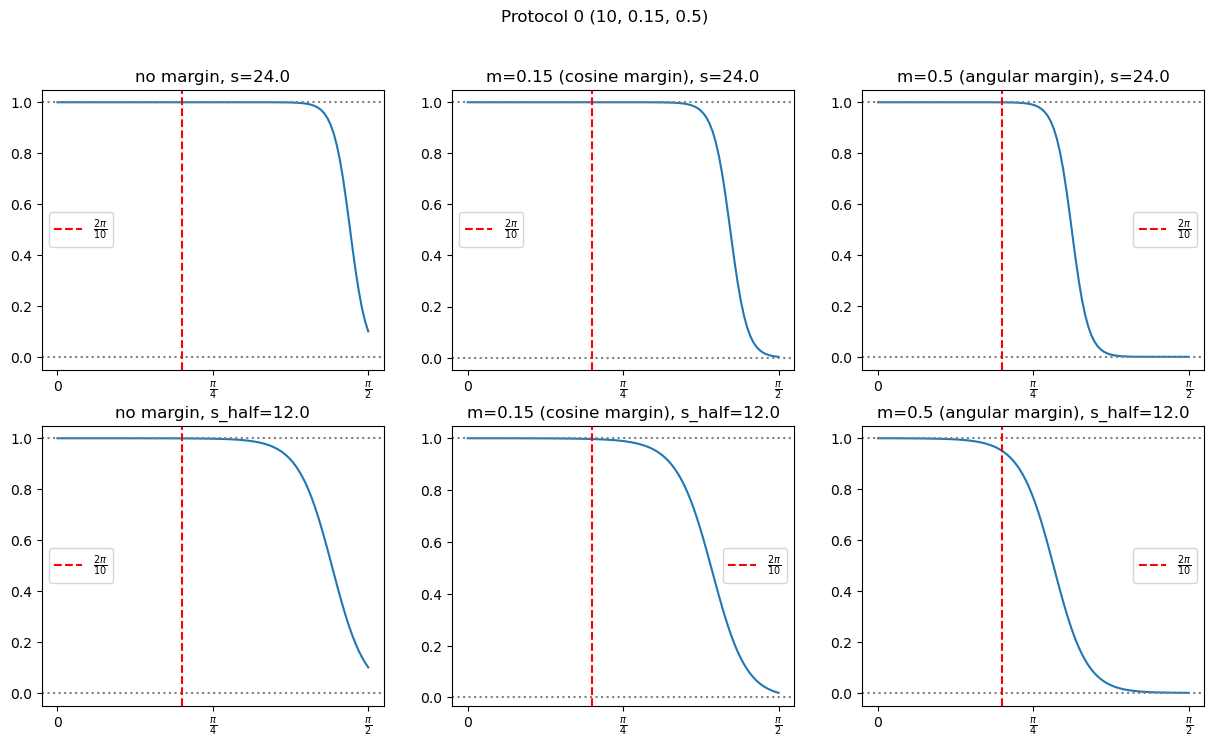

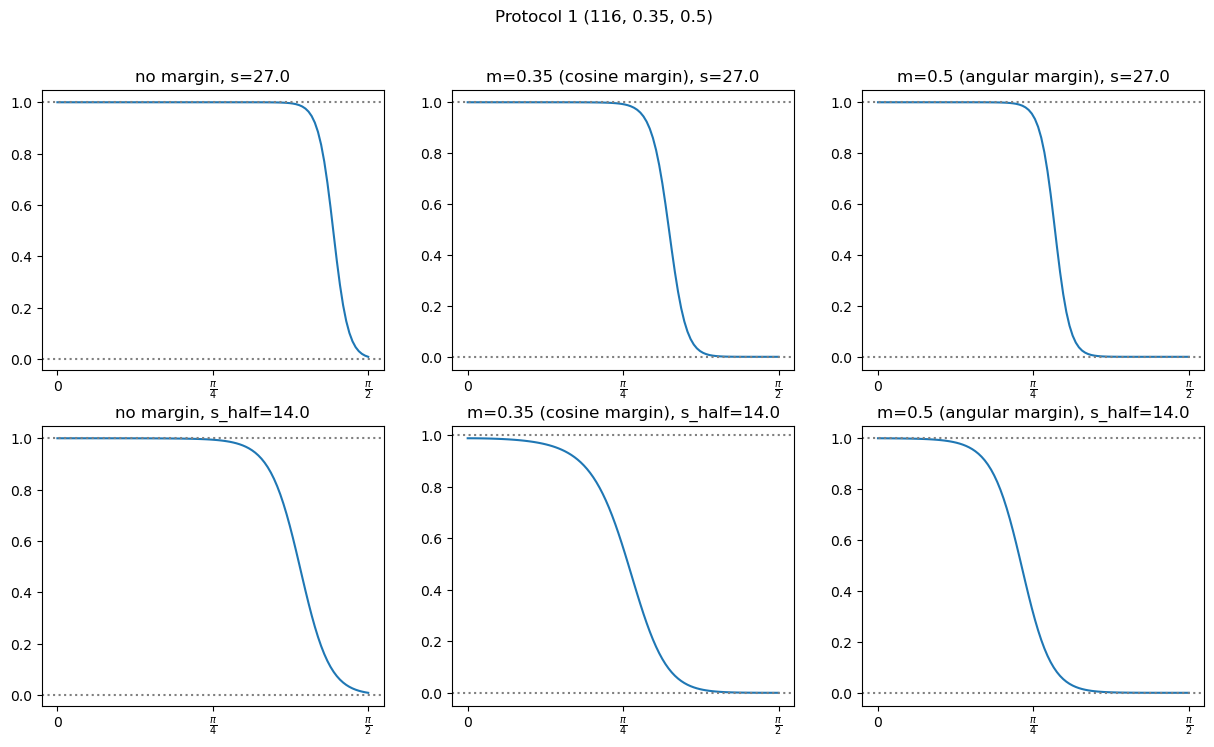

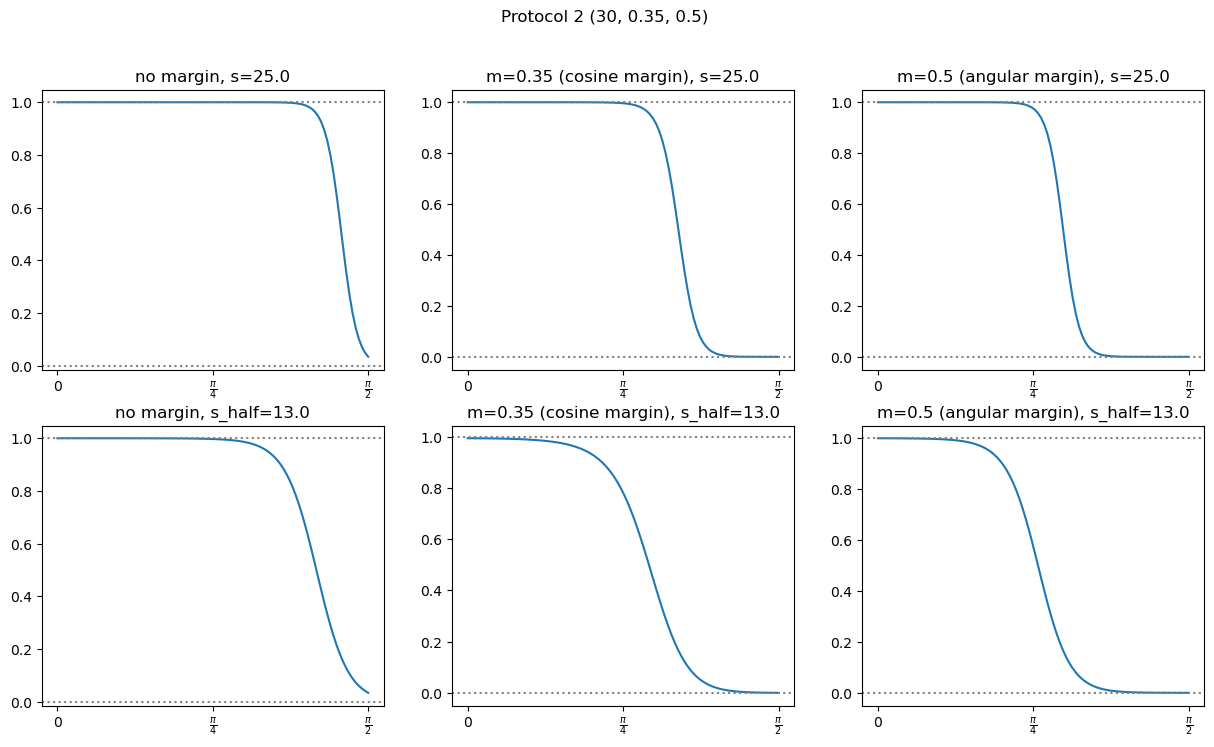

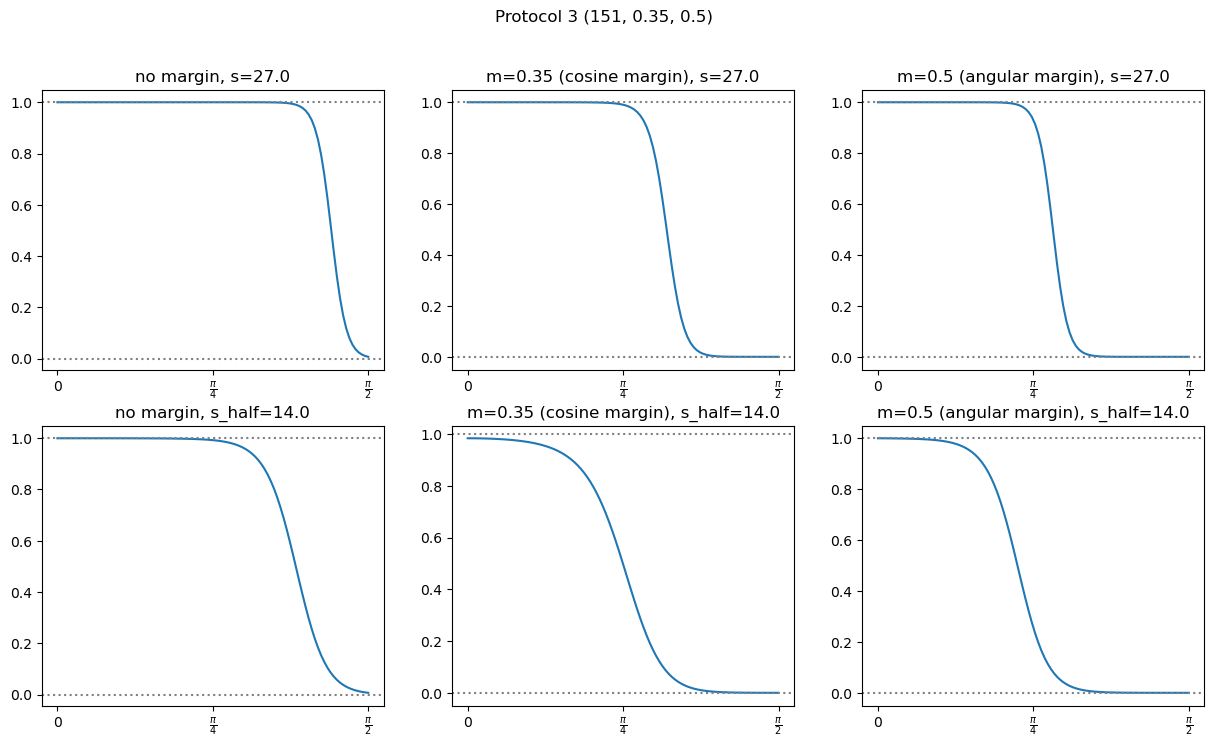

In [142]:
# plot probabilities as function of angle (for given s, m)
def prob_cosine_margin(theta, s, m, C):
    """probability with cosine margin as function of s, m, C"""
    logit_j = np.exp(s * (np.cos(theta) - m))
    return logit_j / (logit_j + (C-1))

def prob_angular_margin(theta, s, m, C):
    """probability with angular margin as function of s, m, C"""
    logit_j = np.exp(s * np.cos(theta + m))
    return logit_j / (logit_j + (C-1))

thetas = np.linspace(0, np.pi/2, 100)

# protocol_index: (C, m_cosine, m_angular) (key: value)
protocols = {
    0: (10, 0.15, 0.5),
    1: (116, 0.35, 0.5),
    2: (30, 0.35, 0.5),
    3: (151, 0.35, 0.5)
}
decimals = 9

for protocol, params in protocols.items():
    C, m_cosine_margin, m_angular_margin = params

    s_ada = l_ada(decimals=decimals, C=C)
    s = np.ceil(s_ada)
    s_half = np.ceil(s_ada/2)

    # s
    p_ij_no_margin_s = []
    p_ij_cosine_margin_s = []  # for s determined via lower bound cosface
    p_ij_angular_margin_s= []  # for s determined via lower bound cosface
    # s_half
    p_ij_no_margin_s_half = []
    p_ij_cosine_margin_s_half = []  # for s determined via lower bound adacos
    p_ij_angular_margin_s_half = []  # for s determined via lower bound adacos
    for theta in thetas:
        # s
        p_ij_no_margin_s.append(prob_cosine_margin(theta, s, 0, C))
        p_ij_cosine_margin_s.append(prob_cosine_margin(theta, s, m_cosine_margin, C))
        p_ij_angular_margin_s.append(prob_angular_margin(theta, s, m_angular_margin, C))
        # s_half
        p_ij_no_margin_s_half.append(prob_angular_margin(theta, s_half, 0, C))
        p_ij_cosine_margin_s_half.append(prob_cosine_margin(theta, s_half, m_cosine_margin, C))
        p_ij_angular_margin_s_half.append(prob_angular_margin(theta, s_half, m_angular_margin, C))


    fig, ax = plt.subplots(2, 3, figsize=(15,8))

    # s
    ax[0,0].plot(thetas, p_ij_no_margin_s)
    ax[0,1].plot(thetas, p_ij_cosine_margin_s)
    ax[0,2].plot(thetas, p_ij_angular_margin_s)
    # s_half
    ax[1,0].plot(thetas, p_ij_no_margin_s_half)
    ax[1,1].plot(thetas, p_ij_cosine_margin_s_half)
    ax[1,2].plot(thetas, p_ij_angular_margin_s_half)
    for i in [0,1]:
        for j in [0,1,2]:
            ax[i,j].axhline(1, linestyle='dotted', color='gray')
            ax[i,j].axhline(0, linestyle='dotted', color='gray')

            # make axis radians
            ax[i,j].set_xticks(x_tick)
            ax[i,j].set_xticklabels(x_label)

            if protocol == 0:
                ax[i,j].axvline(2*np.pi/10, linestyle='dashed', color='red', label=r'$\frac{2\pi}{10}$')
                ax[i,j].legend()
            
    # titles
    # s
    ax[0,0].set_title(f'no margin, s={s}')
    ax[0,1].set_title(f'm={m_cosine_margin} (cosine margin), s={s}')
    ax[0,2].set_title(f'm={m_angular_margin} (angular margin), s={s}')
    # s_half
    ax[1,0].set_title(f'no margin, s_half={s_half}')
    ax[1,1].set_title(f'm={m_cosine_margin} (cosine margin), s_half={s_half}')
    ax[1,2].set_title(f'm={m_angular_margin} (angular margin), s_half={s_half}')

    fig.suptitle(f'Protocol {protocol} {params}')
    fig.show()

## Looking at evaluation scores

In [13]:
scores = np.load('experiments/Protocol_0/cosface_threshold_test_arr_curr.npz')

In [17]:
[k for k in scores.keys()]

['gt', 'logits', 'features', 'scores', 'angles']

In [18]:
scores['logits']

array([[ 189.6681  ,  122.60147 ,  191.20335 , ...,  194.09506 ,
         191.19868 ,  194.78024 ],
       [ 166.64642 ,   30.251019,  166.52911 , ...,  166.12    ,
         166.52957 ,  165.98073 ],
       [ 292.21848 ,  232.69762 ,  295.4129  , ...,  301.5362  ,
         295.40314 ,  303.01102 ],
       ...,
       [  64.091675, -100.51866 ,   61.923904, ...,   57.49604 ,
          61.93067 ,   56.369328],
       [ 168.76585 ,   -8.219255,  167.91168 , ...,  166.01784 ,
         167.91441 ,  165.50502 ],
       [  79.10963 ,  -91.049225,   77.058914, ...,   72.850945,
          77.06532 ,   71.7762  ]], dtype=float32)